In [0]:
!apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [0]:
from zipfile import ZipFile
from google.colab import drive
drive.mount('/content/drive')
!unzip  "/content/drive/My Drive/ML/Train.zip" -d "/content"
!unzip  "/content/drive/My Drive/ML/Test.zip" -d "/content"

In [0]:
import cv2 
import numpy as np
import pandas as pd
import os

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
root = '/content/Train'

img_train = []
label_train = []
for filename in os.listdir(root):
  print(filename)
  if 'digit' in filename:
    print('----------------------')
    print(filename)
    for roots, dirs, files in os.walk(root+'/'+filename):
      
      for file in files:
        im = cv2.imread(os.path.join(roots,file),0)
        im = im[2:30,2:30]
        img_train.append(im)

        label_train.append(int(filename[-1]))


root = '/content/Test'

# img_test = []
# label_test = []
for filename in os.listdir(root):
  # print(filename)
  if 'digit' in filename:
    print('----------------------')
    print(filename)
    for roots, dirs, files in os.walk(root+'/'+filename):
      
      for file in files:
        im = cv2.imread(os.path.join(roots,file),0)
        im = im[2:30,2:30]
        img_train.append(im)
        label_train.append(int(filename[-1]))


character_9_jha
character_6_cha
character_13_daa
character_5_kna
character_1_ka
character_4_gha
character_3_ga
digit_9
----------------------
digit_9
character_7_chha
character_28_la
character_15_adna
character_23_ba
character_8_ja
digit_3
----------------------
digit_3
character_35_tra
character_10_yna
character_32_patalosaw
character_17_tha
character_24_bha
character_27_ra
character_29_waw
character_21_pa
character_30_motosaw
character_22_pha
character_2_kha
digit_4
----------------------
digit_4
digit_2
----------------------
digit_2
character_33_ha
digit_7
----------------------
digit_7
digit_6
----------------------
digit_6
character_19_dha
digit_1
----------------------
digit_1
digit_5
----------------------
digit_5
character_14_dhaa
character_11_taamatar
character_25_ma
character_31_petchiryakha
character_20_na
character_36_gya
character_16_tabala
character_26_yaw
digit_0
----------------------
digit_0
digit_8
----------------------
digit_8
character_34_chhya
character_18_da
cha

In [6]:
print(np.shape(img_train))
# print(np.shape(img_test))
print(np.shape(label_train))
# print(np.shape(label_test))

(20000, 28, 28)
(20000,)


In [7]:
# example of training a gan on mnist
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
from keras import regularizers
import cv2 
import numpy as np
import pandas as pd
import os

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
# define the standalone discriminator model
def discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid')) # sigmoid
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [0]:
# define the standalone generator model
def generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

In [0]:
# define the combined generator and discriminator model, for updating the generator
def gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [0]:
# load and prepare mnist training images
def load_real_samples():
	# load dataset
	trainX = img_train 
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X

In [0]:
# select real samples
def generate_real_images(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

In [0]:
# generate points in latent space as input for the generator
def latentpoints(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [0]:
# use the generator to generate n fake examples, with class labels
def generate_fake_images(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = latentpoints(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [0]:
n_samples = 1000
latent_dim = 100
x_rnd = randn(latent_dim * n_samples)

In [0]:
def generate_fake_images_plt(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = x_rnd
	x_input = x_input.reshape(n_samples, latent_dim)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [0]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=7):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

In [0]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=1000):
	# prepare real samples
	X_real, y_real = generate_real_images(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_images(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real/ fake data: %.0f%% / %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	x_fake, _ = generate_fake_images_plt(g_model, latent_dim, n_samples)
	save_plot(x_fake, epoch)


In [0]:
def show_loss(hist):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()
    path = 'training_hist.png'
    plt.savefig(path)

In [0]:
# train the generator and discriminator
def train_gan(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	hist = {}
	hist['D_losses'] = []
	hist['G_losses'] = []
	for i in range(n_epochs):
		# enumerate batches over the training set
		tmp_d_loss = []
		tmp_g_loss = []
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_images(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_images(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			
      # update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = latentpoints(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			tmp_d_loss.append(d_loss)
			tmp_g_loss.append(g_loss)

		# average d_loss, g_loss
		hist['D_losses'].append(np.mean(tmp_d_loss))
		hist['G_losses'].append(np.mean(tmp_g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			print('>%d' % (i+1))
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
	show_loss(hist)
			

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>10
>20
>30
>40
>50
>60
>70
>80
>90
>100
>110
>120
>130
>140
>150
>160
>170
>180
>190
>200


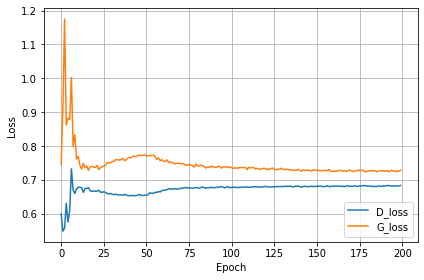

In [63]:
# size of the latent space
latent_dim = 100

# create the discriminator
d_model = discriminator()
# create the generator
g_model = generator(latent_dim)
# create the gan
gan_model = gan(g_model, d_model)

# load image data
dataset = load_real_samples()
# train model
train_gan(g_model, d_model, gan_model, dataset, latent_dim)